# **Bonus - 2 Step Bootstrapping SARSA**

In [1]:
pip install gymnasium matplotlib numpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 925.5/925.5 kB 11.9 MB/s eta 0:00:00


In [2]:
from google.colab import widgets
import gymnasium as gym
from gymnasium import spaces
import matplotlib.pyplot as plt
import numpy as np
import time

In [3]:
class GridEnvironment(gym.Env):
    metadata = { 'render.modes': [] }
    
    def __init__(self):

        self.observation_space = spaces.Discrete(16)
        self.action_space = spaces.Discrete(4)
        self.max_timesteps = 12
        self.done = False

        self.timestep = 0
        self.agent_pos = [0, 0]
        self.goal_pos = [3, 3]
        self.battery_pos = [1, 1]
        self.battery_pos1 = [3, 0]
        self.battery_pos2 = [1, 3]
        self.rock_pos = [2, 2]
        self.rock_pos1 = [3,1]
        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.battery_pos)] = 0.5
        self.state[tuple(self.battery_pos1)] = 0.5
        self.state[tuple(self.battery_pos2)] = 0.5
        self.state[tuple(self.rock_pos)] = -0.5
        self.state[tuple(self.rock_pos1)] = -0.5
        
    def reset(self, **kwargs):

        self.state = np.zeros((4, 4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.battery_pos)] = 0.5
        self.state[tuple(self.battery_pos1)] = 0.5
        self.state[tuple(self.battery_pos2)] = 0.5
        self.state[tuple(self.rock_pos)] = -0.5
        self.state[tuple(self.rock_pos1)] = -0.5
        observation = self.state.flatten()
       
        return observation
    
    def step(self, action):

        if action == 0:
          self.agent_pos[0] += 1
        if action == 1:
          self.agent_pos[0] -= 1
        if action == 2:
          self.agent_pos[1] += 1
        if action == 3:
          self.agent_pos[1] -= 1

        self.agent_pos = np.clip(self.agent_pos, 0, 3)

        self.state = np.zeros((4,4))
        self.state[tuple(self.agent_pos)] = 1
        self.state[tuple(self.goal_pos)] = 0.5
        self.state[tuple(self.battery_pos)] = 0.5
        self.state[tuple(self.battery_pos1)] = 0.5
        self.state[tuple(self.battery_pos2)] = 0.5
        self.state[tuple(self.rock_pos)] = -0.5
        self.state[tuple(self.rock_pos1)] = -0.5
        observation = self.state.flatten()
        
        reward = 0
        if np.array_equal(self.agent_pos, self.goal_pos):
            reward += 25
        elif np.array_equal(self.agent_pos, self.battery_pos):
            reward += 5
        elif np.array_equal(self.agent_pos, self.battery_pos1):
            reward += 10
        elif np.array_equal(self.agent_pos, self.battery_pos2):
            reward += 15 
        elif np.array_equal(self.agent_pos, self.rock_pos):
            reward -= 5
        elif np.array_equal(self.agent_pos, self.rock_pos1):
            reward -= 10
        
        self.timestep += 1 
        return self.agent_pos, reward, self.done
        
    def render(self):
        plt.imshow(self.state,cmap='coolwarm')

In [4]:
class RandomAgent:
  def __init__(self, env):
    self.env = env
    self.observation_space = env.observation_space
    self.action_space = env.action_space

  def step(self, obs):
    return np.random.choice(self.action_space.n)

In [141]:
def sarsa(discount_factor = 0.95, timesteps =15, num_episodes =1000):
  env = GridEnvironment()
  obs = env.reset()
  learning_rate = 0.15
  start_epsilon = 0.99 
  current_state = 0 
  actions = [0,1,2,3]
  q_table = np.zeros((16, 4))
  rewards_list, num_timesteps, epsilon_values= [], [], []
  states = {}
  index_value ,row_val= 0,0
  while row_val < 4:
      column_val = 0
      while column_val < 4:
        states[(row_val,column_val)] = index_value
        index_value = index_value + 1
        column_val = column_val + 1
      row_val = row_val + 1
  done = False 
  total_episodes = num_episodes
  first_exploration_rate = 0.8
  last_exploration_rate = 0.05
  avg_timesteps = 0
  epsilon = 1 
  decay_factor = (last_exploration_rate/first_exploration_rate)**(1.0/total_episodes)
  for episode in range(1, total_episodes+1):
    obs = env.reset()
    current_state = 0 
    total_rewards = 0
    timestep = 0
    rand_num = np.random.random()
    if epsilon > rand_num:
      action = np.random.choice(actions)
    else:
      action = np.argmax(q_table[current_state])
    while timestep < timesteps:
    
      rand_num = np.random.random()
      if start_epsilon > rand_num: 
          
          next_state_pos, reward, done= env.step(action)
          next_state = states[tuple(next_state_pos)]
          rand_num = np.random.random()
          if epsilon > rand_num:
            next_action = np.random.choice(actions)
          else:
            next_action = np.argmax(q_table[next_state]) 
          q_table[current_state][action] = q_table[current_state][action] + learning_rate*(reward + discount_factor*q_table[next_state][next_action] - q_table[current_state][action])

          total_rewards += reward 
          timestep += 1
          current_state = next_state 
          action = next_action
          
          if done == True: 
            done = False
            break        
    avg_timesteps += timestep
    num_timesteps.append(avg_timesteps)

    rewards_list.append(total_rewards)
    epsilon_values.append(epsilon) 
    if epsilon > 0.01: 
        epsilon = epsilon*decay_factor
    else:
        epsilon = 0.01

  print("Q Table: \n", q_table)
  return q_table, rewards_list, epsilon_values

In [138]:
env = GridEnvironment()
obs = env.reset()
agent = RandomAgent(env)
def epsilon_greedy(q_table, episode, current_state, start_epsilon, min_epsilon, decay_rate):
    eps = max(min_epsilon, (start_epsilon - min_epsilon) * np.exp(-decay_rate * episode))
    rand_num = np.random.uniform(0, 1)  
    if eps > rand_num: 
        action = agent.step(obs)
    else:
        action = np.argmax(q_table[current_state, :])
    return action

def sarsa_2step(q_table, num_episodes=1500, timesteps=15, learning_rate=0.1, discount_factor=0.95):
    rewards_list ,epsilon_values= [],[]
    start_epsilon = 1.0
    min_epsilon = 0.0
    decay_rate = 0.005
    
    for episode in range(num_episodes):
        env = GridEnvironment()
        obs = env.reset()
        agent = RandomAgent(env)
        done = False
        if 1 not in obs.tolist():
            continue
        current_state = obs.tolist().index(1)
        action = epsilon_greedy(q_table, episode, current_state, start_epsilon, min_epsilon, decay_rate)
        total_reward = 0

        for _ in range(timesteps):
            obs1, reward, done = env.step(action)
            if 1 not in obs1.tolist():
                continue
            next_state = obs1.tolist().index(1)
            next_action = epsilon_greedy(q_table, episode, next_state, start_epsilon, min_epsilon, decay_rate)
            next_next_action = epsilon_greedy(q_table, episode, next_state, start_epsilon, min_epsilon, decay_rate)

            q_table[current_state][action] += learning_rate * (reward + discount_factor *
                (q_table[next_state][next_action] + discount_factor * q_table[next_state][next_next_action]) -
                q_table[current_state][action])

            total_reward += reward

            if done:
                break

            current_state = next_state
            action = next_action

        rewards_list.append(total_reward)
        epsilon_values.append(max(min_epsilon, (start_epsilon - min_epsilon) * np.exp(-decay_rate * episode)))

    print("Q Table: \n", q_table)
    return q_table, rewards_list, epsilon_values


In [146]:
q_table = np.zeros((16, 4))
q_table, rewards_list ,epsilon_values=sarsa_2step(q_table, num_episodes=2500, timesteps=20, learning_rate=0.1, discount_factor=0.9)

Q Table: 
 [[5.11126058e+09 1.95066805e+02 1.80399919e+10 4.46083912e+12]
 [2.97104988e+11 1.71132284e+02 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+

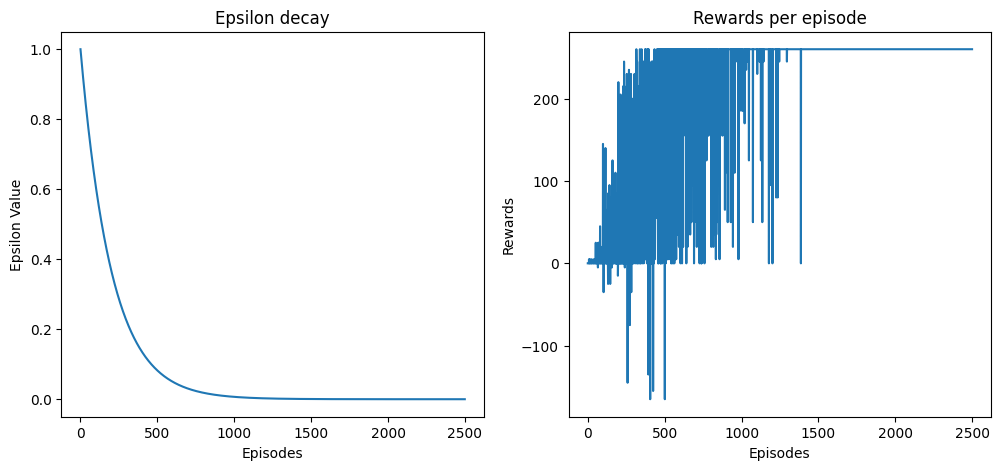

In [140]:
fig_1, axs_1 = plt.subplots(1, 2, figsize=(12,5))

axs_1[0].plot(epsilon_values)
axs_1[0].set(title="Epsilon decay", xlabel="Episodes", ylabel="Epsilon Value")

axs_1[1].plot(rewards_list)
axs_1[1].set(title="Rewards per episode", xlabel="Episodes", ylabel="Rewards")

plt.show()

Q Table: 
 [[483.74700487 431.26871345 466.18515832 436.25244353]
 [ 94.01615606  71.44059779  70.18473525 182.29877421]
 [118.1262978   67.64855121  95.00500032  67.52084326]
 [242.02713237 117.60881482 118.06695314  67.62107724]
 [ 22.52458242 196.06239412  60.19250014  53.17218341]
 [ 95.50394096  78.68530213 194.29752079  85.42958983]
 [232.26757071  96.76372492 333.8821333  144.89794198]
 [427.79748296 173.00308324 308.29749472 214.64099487]
 [ 98.08780651  65.83083075  33.06621041  36.74638886]
 [174.80185867 113.19523955 343.35026759  63.25534973]
 [344.51838174 240.7306613  447.83493903 202.44348535]
 [479.480954   396.75717848 437.36391019 399.33438333]
 [101.18855928  52.64843706 225.96069965 108.06868961]
 [211.73187975 240.12077639 416.89649461 158.03129856]
 [427.90481465 392.81044657 480.3862529  348.88489663]
 [485.15476692 437.63338674 478.58989906 453.12719401]]


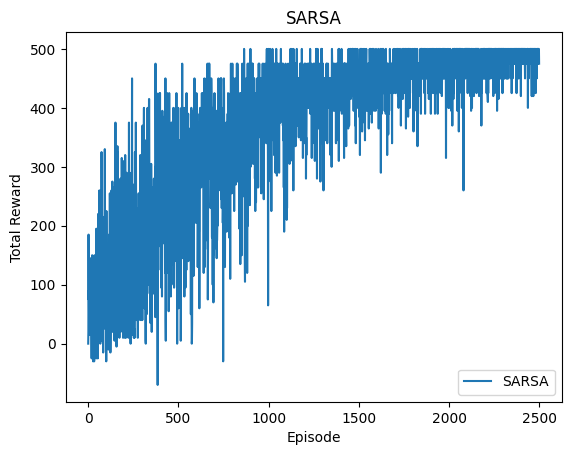

In [151]:

q_table_sarsa, rewards_list_sarsa, epsilon_values_sarsa = sarsa(discount_factor = 0.95, timesteps = 20, num_episodes = 2500)

plt.plot(rewards_list_sarsa, label='SARSA')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('SARSA')
plt.legend()
plt.show()

